In [5]:
import os
import numpy as np
import h5py
import pandas as pd
import concurrent.futures

from tifffile import imread
import matplotlib.pyplot as plt

# Check current backend
print(f"Current backend: {plt.get_backend()}")

# If running in Jupyter or IPython, ensure inline plotting
%matplotlib inline

Current backend: module://matplotlib_inline.backend_inline


In [6]:
# Load parameters.csv to get scan information and metadata
csv_path = '/root/capsule/data/iGluSnFR_simulations_default_12/parameters.csv'  # Path to your parameters.csv
params_df = pd.read_csv(csv_path)

# Create a dictionary to map SimDescription (e.g., 1, 2, 3) to their corresponding metadata
metadata_dict = {}
for _, row in params_df.iterrows():
    sim_description = str(row['SimDescription'])  # Ensure it's a string for matching folder names like '1', '2', etc.
    metadata_dict[sim_description] = {
        'motionAmp': row['motionAmp'],
        'brightness': row['brightness'],
        'nsites': row['nsites'],
        'scan': row['scan']
    }

In [7]:
# Function to process each .h5 file and extract MotionC and MotionR along with metadata
def process_h5_file(h5_file_path, sim_description, model_name):
    try:
        with h5py.File(h5_file_path, 'r') as h5_file:
            # Check for MotionC at different levels
            if 'MotionC' in h5_file.keys():
                motion_c_data = h5_file['MotionC'][:]
            elif 'C' in h5_file.keys():
                motion_c_data = h5_file['C'][:]
            elif 'aData/motionC' in h5_file:
                motion_c_data = h5_file['aData/motionC'][:]  # Check for aData/motionC
            else:
                motion_c_data = None

            # Check for MotionR at different levels
            if 'MotionR' in h5_file.keys():
                motion_r_data = h5_file['MotionR'][:]
            elif 'R' in h5_file.keys():
                motion_r_data = h5_file['R'][:]
            elif 'aData/motionR' in h5_file:
                motion_r_data = h5_file['aData/motionR'][:]  # Check for aData/motionR
            else:
                motion_r_data = None

            # Retrieve metadata for this SimDescription (folder name)
            metadata = metadata_dict.get(sim_description, {})
            
            return (sim_description, motion_c_data, motion_r_data, metadata, model_name)
    except Exception as e:
        print(f"Error reading {h5_file_path}: {e}")
        return (sim_description, None, None, {}, model_name)

# Load alignment data

In [8]:
h5_file_path = '/root/capsule/data/iGluSnFR_simulations_default_12_registered9/stripRegisteration/1/SIMULATION_scan_00001-1_Trial1_ALIGNMENTDATA.h5'
sim_description = 1
model_name = 'stripRegisteration'
_, MotionC, MotionR, _, _  = process_h5_file(h5_file_path, sim_description, model_name)

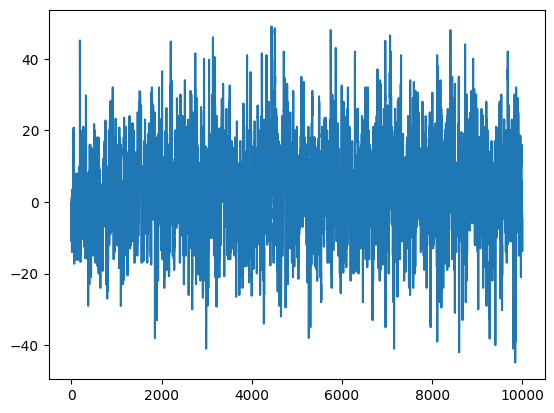

In [9]:
plt.plot(MotionC)

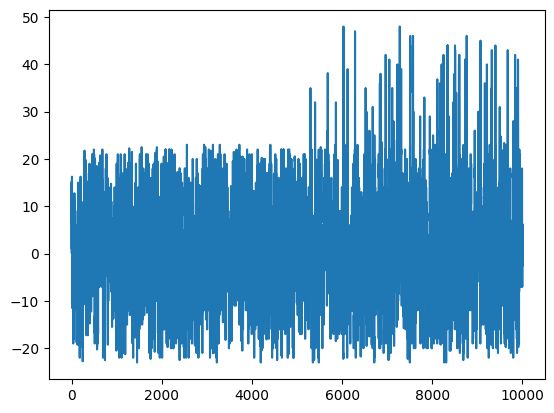

In [10]:
plt.plot(MotionR)

# Calculate the top 5 percentile of motion

In [24]:
motion_total = np.sqrt((abs(MotionC)/128)**2 + (abs(MotionR)/50)**2)

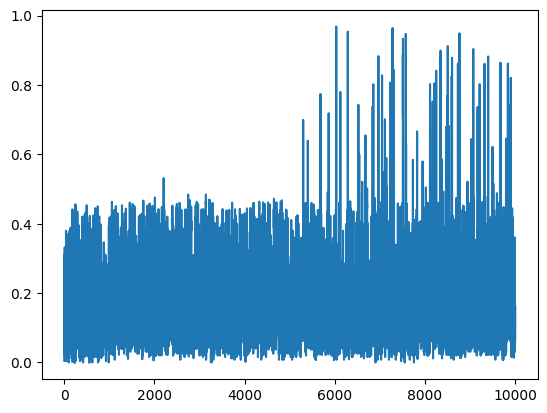

In [25]:
plt.plot(motion_total)

In [16]:
# Calculate the 95th percentile (top 5 percentile threshold)
top_5_percentile = np.percentile(motion_total, 95)

# Extract values above or equal to the 95th percentile
top_5_percentile_values = motion_total[motion_total >= top_5_percentile]
top_5_percentile_indices = np.where(motion_total >= top_5_percentile)[0]

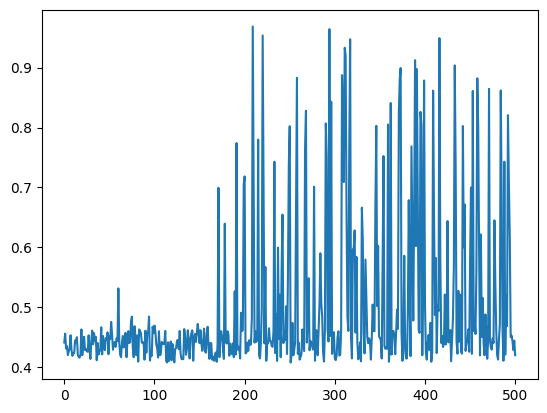

In [17]:
plt.plot(top_5_percentile_values)

In [23]:
top_5_percentile_indices.shape

(512,)

# Load registered movie and based on index of top percentage get those frames

In [19]:
movie = imread('/root/capsule/data/iGluSnFR_simulations_default_12_registered9/stripRegisteration/1/SIMULATION_scan_00001-1_Trial1_DOWNSAMPLED-1x.tif')

In [20]:
movie_top_motion = movie[top_5_percentile_indices, :,:]
movie_top_motion_mean = np.nanmean(movie_top_motion, axis=0) 

/tmp/ipykernel_787/343877450.py:2: RuntimeWarning: Mean of empty slice
  movie_top_motion_mean = np.nanmean(movie_top_motion, axis=0)


In [23]:
movie_top_motion.shape # Frames with the most motion

(501, 111, 218)

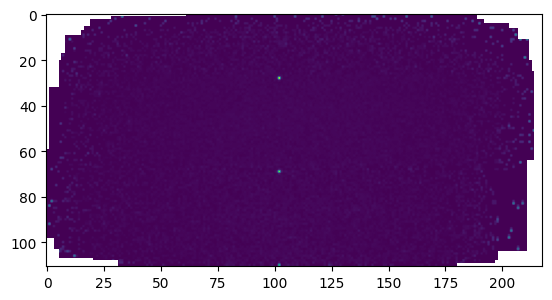

In [22]:
plt.imshow(movie_top_motion_mean)

In [39]:
movie_top_motion_mean.shape

(111, 218)

# Calculate correlation of mean of frames with most motion and every frame of the movie with most motion

Correlation Calculation Complete:
Mean correlation: 0.05827920056788743
Median correlation: 0.0543343025738759
Min correlation: 0.010787598807881701
Max correlation: 0.17063684921747535
Standard deviation of correlations: 0.023610875445082058


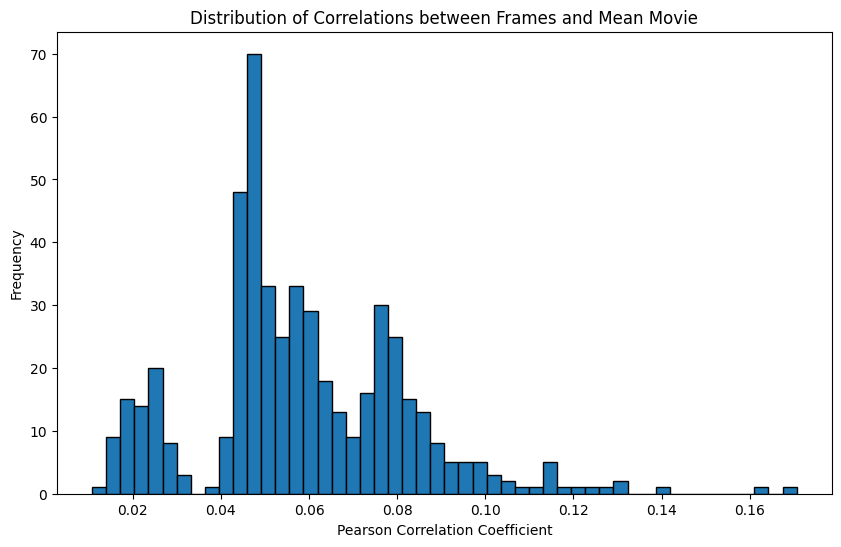

In [26]:
from scipy.stats import pearsonr

movie_most_motion = np.nan_to_num(movie_top_motion, nan=0.0)
mean_movie = np.nan_to_num(movie_top_motion_mean, nan=0.0)

# Flatten the mean movie for correlation calculation
mean_movie_flat = mean_movie.flatten()

# Initialize an array to store correlations
correlations = np.zeros(movie_most_motion.shape[0])

# Calculate correlation for each frame
for i in range(movie_most_motion.shape[0]):
    frame_flat = movie_most_motion[i].flatten()  # Flatten the current frame
    correlations[i], _ = pearsonr(frame_flat, mean_movie_flat)  # Pearson correlation

# Output basic statistics of correlations
print("Correlation Calculation Complete:")
print("Mean correlation:", np.mean(correlations))
print("Median correlation:", np.median(correlations))
print("Min correlation:", np.min(correlations))
print("Max correlation:", np.max(correlations))
print("Standard deviation of correlations:", np.std(correlations))

# Optional: Visualize correlation distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(correlations, bins=50, edgecolor='black')
plt.title('Distribution of Correlations between Frames and Mean Movie')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Frequency')
plt.show()

In [27]:
print('Mean of correlations:', np.mean(correlations))

Mean of correlations: 0.05827920056788743
